
# 🚀 **Fine-Tuning Florence-2 Model for ImageCLEFmed-MEDVQA-GI-2025's Subtask 1**

🔍 Subtask 1: Algorithm Development for Question Interpretation and Response

This notebook demonstrates the **fine-tuning process** for Microsoft's **Florence-2 model** on the **Kvasir-VQA dataset**, which contains **medical images 🏥** with related **questions ❓** and **answers ✅**.  

🔗 **Competition Repository:** [ImageCLEFmed-MEDVQA-GI-2025](https://github.com/simula/ImageCLEFmed-MEDVQA-GI-2025) 🌐  

---

## 🔧 **Steps Included**:  
- ⚙️ **Environment setup** and installation of requirements 📦  
- 🧩 **Model and dataset loading** 🗂️  
- 🧹 **Data preprocessing** 🧼  
- 🤖 **Model fine-tuning** using Hugging Face's `Trainer` API 🏃‍♂️  
- 💾 **Saving and pushing** the trained model to Hugging Face Hub 🌍  
- 🔄 **Loading the saved model** from HuggingFace for inference 🎛️  
- 🖼️🤔 **Inference on a sample image** and question 💡  

In [65]:
# Install required libraries
!pip install datasets evaluate rouge_score

# Import necessary modules
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoProcessor, Trainer, TrainingArguments
import torch
import os

# comment this (RECOMMENDED) if you want to log the run to Weights & Biases
os.environ["WANDB_MODE"] = "offline" #

## Load Model and Dataset

- Load Florence-2 base model and processor.
- Freeze vision tower parameters for efficiency.
- Load Kvasir-VQA dataset and perform train-validation split.

In [65]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Florence-2 model
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True).to(device)

# Freeze vision tower
for param in model.vision_tower.parameters():
    param.requires_grad = False

# Load processor
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)

# Load dataset
ds = load_dataset("SimulaMet-HOST/Kvasir-VQA")['raw']
dataset = ds.train_test_split(test_size=0.0001)  ### using 1% of total data for DEMO only
dataset = dataset['test'].train_test_split(test_size=0.1) ### splitting 1% data into 90% train and 10% test
train_dataset, val_dataset = dataset['train'], dataset['test']

## Data Collation Function

Process images and questions into tensors suitable for the model.

In [3]:
def collate_fn(batch):
    questions = [f"<MedVQA>{x['question']}" for x in batch]
    images = [x["image"].convert("RGB") if x["image"].mode != "RGB" else x["image"] for x in batch]
    answers = [x["answer"] for x in batch]

    inputs = processor(text=questions, images=images, return_tensors="pt", padding=True)
    labels = processor.tokenizer(answers, return_tensors="pt", padding=True).input_ids
    labels[labels == processor.tokenizer.pad_token_id] = -100
    inputs["labels"] = labels
    return inputs

In [4]:
# (optional) if you want to evaluate with NLP or other metrics

import evaluate
import numpy as np

bleu, meteor, rouge = map(evaluate.load, ["bleu", "meteor", "rouge"])

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = processor.tokenizer.batch_decode(np.argmax(preds[0], axis=-1), skip_special_tokens=True)
    labels = processor.tokenizer.batch_decode(np.where(labels != -100, labels, processor.tokenizer.pad_token_id), skip_special_tokens=True)
    preds, labels = [p.strip() for p in preds], [l.strip() for l in labels]

    return {
        "bleu": bleu.compute(predictions=preds, references=[[l] for l in labels])["bleu"],
        "meteor": meteor.compute(predictions=preds, references=labels)["meteor"],
        "rougeL": rouge.compute(predictions=preds, references=labels)["rougeL"],
    }

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Training Configuration

Define training arguments for model optimization.

In [5]:
training_args = TrainingArguments(
    output_dir="./Florence-2-vqa",
    per_device_train_batch_size=3, #### adjust as per GPU memory, 3 for Colab's T4
    num_train_epochs=3,            #### adjust as per resources
    learning_rate=1.8e-6,
    weight_decay=0.01,
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    report_to="wandb",
    save_total_limit=3,
    remove_unused_columns=False
)


## Model Training

Train the Florence-2 model using Hugging Face's Trainer API.

In [65]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics # if you want to evaluate with NLP or other metrics (optional)
)
trainer.train()

## Save Model and Push to Hugging Face Hub

Save the trained model locally and upload it to Hugging Face Hub for public access.

In [10]:
model.save_pretrained("./Florence-2-vqa/final")
from huggingface_hub import login
login()
model.push_to_hub("Florence-2-vqa")
processor.push_to_hub("Florence-2-vqa")

# Load the saved model for inference from the Hugging Face Hub.
<!--   -->

In [18]:
# Use your model repo name instead of SushantGautam/Florence-2-vqa-demo
model_hf = AutoModelForCausalLM.from_pretrained("SushantGautam/Florence-2-vqa-demo", trust_remote_code=True).to(device)
## change needed in uploaded config.json on HuggingFace: LINE 165, "model_type": "" --> "model_type": "davit"

config.json:   0%|          | 0.00/5.75k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

## Inference on a random sample from the validation set

Q: How many findings are present?
Model: 1
GT: 1


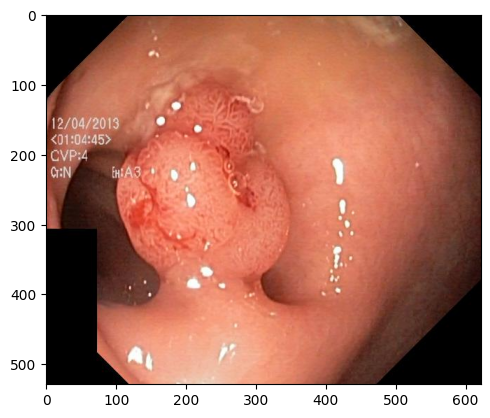

In [65]:
# ReRun this block to generate for new ramdom sample
import random
sample = [val_dataset[random.randint(0, len(val_dataset)-1)]] # rerun this block to generate new sample
import matplotlib.pyplot as plt; plt.imshow(sample[0]['image'])
inputs = collate_fn(sample)
inputs = {k: v.to(device) for k, v in inputs.items() if k not in ['labels', 'attention_mask']}

with torch.no_grad():
    output = model_hf.generate(**inputs)

print(f"Q: {sample[0]['question']}\nModel: {processor.tokenizer.decode(output[0], skip_special_tokens=True)}\nGT: {sample[0]['answer']}")

# Good luck!